# Прогнозирование заказов такси

### Содержание работы

**[Введение](#0)**

**[1. Загрузка и предобработка данных](#1)** 
   
**[2. Анализ данных](#2)**
     
**[3. Построение моделей](#3)** 

**[4. Тестирование](#4)** 
    
**[Заключение](#5)**

## Описание проекта <a id="0"></a>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, **необходимо спрогнозировать количество заказов такси на следующий час**. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Для анализа доступны данные количества заказов с 1 марта по 31 августа 2018 г. за каждые 10 мин.

## Шаг 1. Загрузка и преобработка данных <a id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import lightgbm as lgb

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm

Откроем файл с данными и сохраним в переменной `taxi`.

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace = True)
print(taxi.index.is_monotonic)
print(taxi.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Имеем 26496 наблюдений. Пропущенные значения отсутствуют.

Ресемплируем данные по 1 часу:

In [3]:
taxi = taxi.resample('1H').sum()

In [4]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Шаг 2. Анализ <a id="2"></a>

Построим график числа заказов за весь исследуемый период:

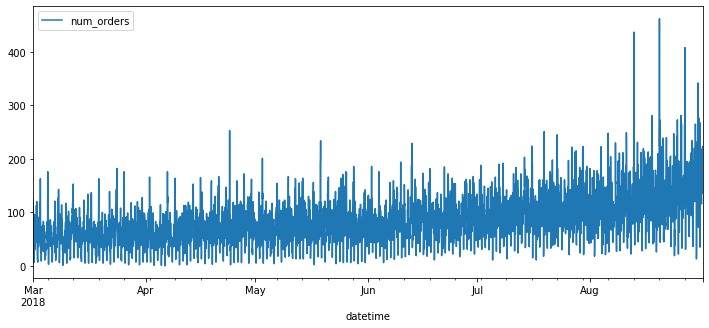

In [5]:
taxi.plot(figsize=(12,5));

График неинформативен из-за большого числа колебаний. Для анализа общего тренда ресемплируем данные по 1 дню и построим соответствующий график. Также построим график скользящей средней по  дням:

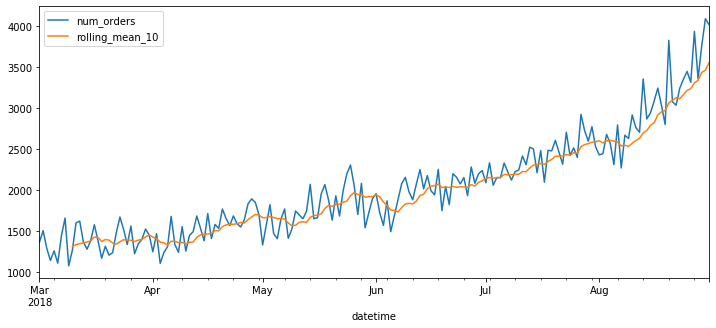

In [6]:
daily = taxi.resample('1D').sum()
daily['rolling_mean_10'] = taxi.resample('1D').sum().rolling(10).mean()
daily.plot(figsize=(12,5));

Наблюдаем растущий нелинейный тренд.

Вернёмся к почасовому интервалу и построим график числа заказов за последний месяц:

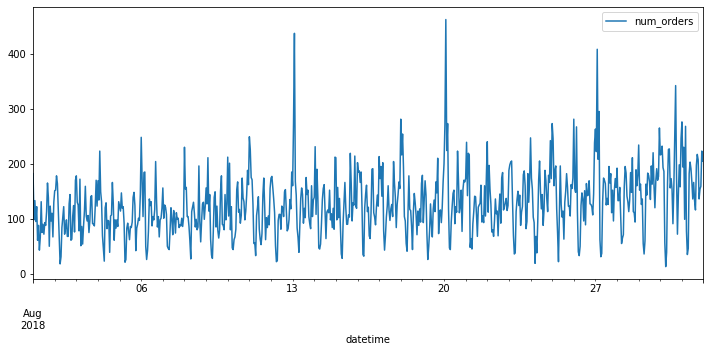

In [7]:
taxi['2018-08-01':'2018-08-31'].plot(figsize=(12,5));

На графике заметны периодические колебания. Разложим временной ряд на тренд и сезонность и построим соответствующие графики:

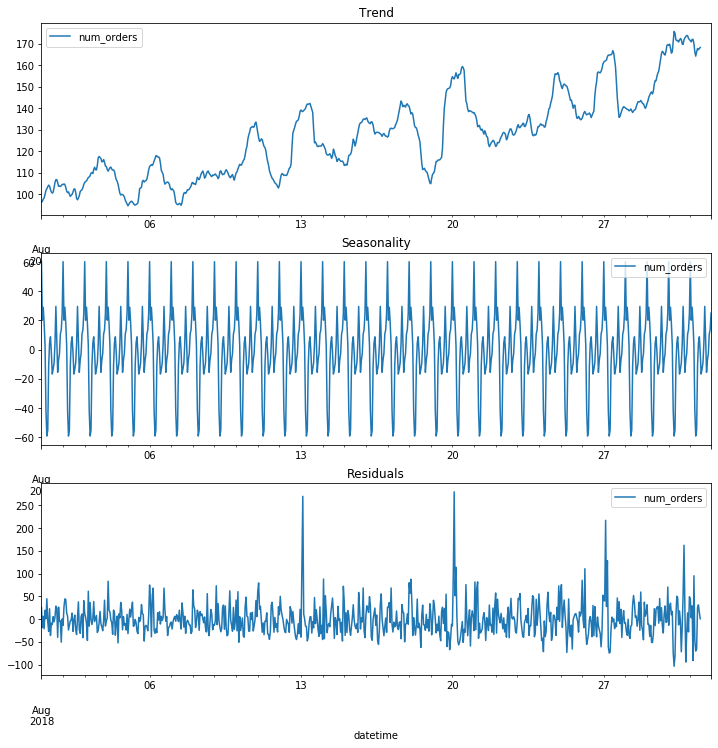

In [8]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend');

plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality');

plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals');

Согласно графику сезонных колебаний, периодичность циклических изменений временного ряда составляет 1 день. 

Построим график полученного в результате декомпозиции тренда за весь исследуемый период. Также построим графики скользящей средней этого тренда по 10 и 30 дням:

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Да, явная дневная сезонность, молодец, что заметил это. Также верно определен тренд на повышение количества заказов.

</div>


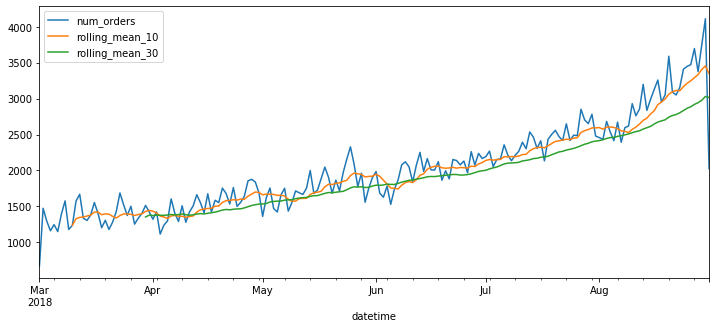

In [9]:
daily_trend = decomposed.trend.resample('1D').sum()
daily_trend['rolling_mean_10'] = decomposed.trend.resample('1D').sum().rolling(10).mean()
daily_trend['rolling_mean_30'] = decomposed.trend.resample('1D').sum().rolling(30).mean()
daily_trend.plot(figsize=(12,5));

Тренд не является линейным, хоть и близок к нему.

Для улчушения качества прогноза линейной регрессии логарифмируем данные, чтобы перейти к изучению линейных зависимостей:

In [10]:
taxi['num_orders_log'] = np.log(taxi['num_orders'].replace(0,0.1))
# нулевое значение заменяем почти нулевым для возможности вычисления логарифма

Построим график подневного логарифмированного числа заказов. Также построим графики скользящей средней по 10 и 30 дням:

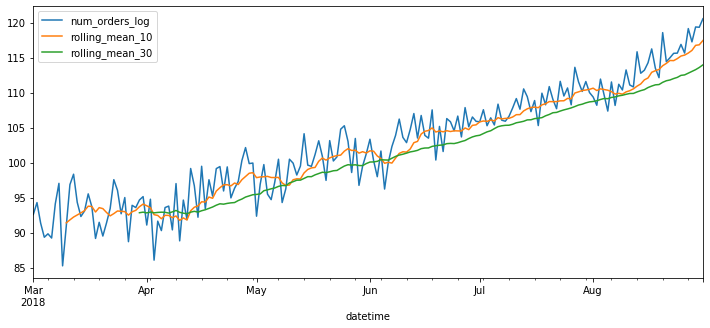

In [11]:
daily_log = taxi.drop('num_orders', axis=1).resample('1D').sum()
daily_log['rolling_mean_10'] = taxi.drop('num_orders', axis=1).resample('1D').sum().rolling(10).mean()
daily_log['rolling_mean_30'] = taxi.drop('num_orders', axis=1).resample('1D').sum().rolling(30).mean()
daily_log.plot(figsize=(12,5));

Тренд стал линеным, при этом график 30-дневной скользящей средней представляет собой практически идеально ровную прямую.

Изучим попарные зависимости почасового логарифмированного числа заказов среди разных месяцев. 

Для этого сперва создадим датафрейм с почасовым логарифмированным числом заказов за каждый месяц:

In [14]:
monthes = pd.DataFrame(index=taxi[('2018-3')].index).reset_index().drop('datetime', axis=1).iloc[:720]

for month in taxi.index.month.unique():
    monthes['month_{}'.format(month)] = taxi[('2018-{}').format(month)]['num_orders_log'].iloc[:720].values
    
#ограничимся 30 днями в каждом месяце, чтобы выборки имели одинаковый размер

In [15]:
monthes

,month_3,month_4,month_5,month_6,month_7,month_8
0,4.820282,4.442651,4.394449,4.770685,4.644391,5.204007
1,4.442651,3.737670,4.304065,4.343805,4.430817,4.584967
2,4.262680,3.526361,4.007333,4.709530,4.605170,4.890349
3,4.189655,3.178054,4.430817,4.882802,4.488636,4.553877
4,3.761200,3.663562,4.343805,4.174387,4.682131,4.804021
...,...,...,...,...,...,...
715,4.158883,4.174387,4.624973,4.736198,4.828314,4.276666
716,4.330733,4.110874,4.584967,4.369448,4.330733,4.955827
717,4.406719,4.477337,4.744932,4.595120,4.804021,5.288267
718,4.691348,4.442651,4.369448,4.248495,4.709530,5.062595


Построим матрицу корреляции для столбцов полученного датафрейма:

In [16]:
monthes.corr()

,month_3,month_4,month_5,month_6,month_7,month_8
month_3,1.000000,0.665621,0.662665,0.573913,0.539265,0.587394
month_4,0.665621,1.000000,0.724866,0.628697,0.610281,0.619449
month_5,0.662665,0.724866,1.000000,0.639505,0.637562,0.636103
month_6,0.573913,0.628697,0.639505,1.000000,0.671688,0.687985
month_7,0.539265,0.610281,0.637562,0.671688,1.000000,0.660948
month_8,0.587394,0.619449,0.636103,0.687985,0.660948,1.000000


Наблюдаем умеренную/умеренно-сильную линейную корреляцию между почасовым логарифмированным числом заказов за любую взятую пару месяцев. При этом в среднем наибольшая корреляция наблюдается между соседними месяцами.

Добавим к исходному датафрейму столбцы с признаками, в том числе час заказа, месячный день, день недели. Также добавим лаги от 1 до 732 часов (~ 1 месяц), так как именно на по помесячных данных выстраивается практически строго линейный тренд. Кроме того, добавим скользящие средние за 1 месяц, 1 неделю, 1 день и полдня.

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders_log'].shift(lag)

    for roll in rolling_mean_size:
        data['rolling_mean_{}'.format(roll)] = data['num_orders_log'].shift().rolling(roll).mean()

In [18]:
make_features(taxi, 732, [12, 24, 168, 732])

## Шаг 3. Построение моделей <a id="3"></a>

Разделим данные на обучающую, тренировочную и тестовую выборки. Стандартизируем признаки.

In [19]:
train_valid, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=test.shape[0])

train = train.dropna()

scaler = StandardScaler()
scaler.fit(train.drop(['num_orders', 'num_orders_log'], axis=1))

X_train = pd.DataFrame(scaler.transform(train.drop(['num_orders', 'num_orders_log'], axis=1)),\
                       index=train.drop(['num_orders', 'num_orders_log'], axis=1).index,\
                       columns=train.drop(['num_orders', 'num_orders_log'], axis=1).columns)

X_valid = pd.DataFrame(scaler.transform(valid.drop(['num_orders', 'num_orders_log'], axis=1)),\
                       index=valid.drop(['num_orders', 'num_orders_log'], axis=1).index,\
                       columns=valid.drop(['num_orders', 'num_orders_log'], axis=1).columns)

X_test = pd.DataFrame(scaler.transform(test.drop(['num_orders', 'num_orders_log'], axis=1)),\
                       index=test.drop(['num_orders', 'num_orders_log'], axis=1).index,\
                       columns=test.drop(['num_orders', 'num_orders_log'], axis=1).columns)

y_train = train['num_orders']
y_train_log = train['num_orders_log']

y_valid = valid['num_orders']
y_valid_log = valid['num_orders_log']

y_test = test['num_orders']
y_test_log = test['num_orders_log']

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(2800, 739)
(442, 739)
(442, 739)


Для начала рассчитаем метрики качества базовых (отправных) моделей:

In [20]:
pred_mean = np.ones(y_test.shape) * y_train.mean()
print("RMSE:", mean_squared_error(y_test, pred_mean)**.5)

RMSE: 84.43117008837115


Модель, возвращающая среднее значение числа заказов в среднем ошибается на 84 заказа.

In [21]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_valid.iloc[-1]

print("RMSE:", mean_squared_error(y_test, pred_previous)**.5)

RMSE: 58.856486242815066


Модель, возвращающая число заказов за предыдущий час, в среднем ошибается на 58 заказов.

Построим модель линейной регрессии. Модель строится по логарифмированным данным; метрики качества вычислены по экспоненцированным предсказаниям (и исходным ответам).

In [22]:
lr = LinearRegression()
lr.fit(X_train, (y_train_log))

lr_pred_train = np.exp(lr.predict(X_train))
lr_pred_valid = np.exp(lr.predict(X_valid))

rmse_train = mean_squared_error(y_train, lr_pred_train)**.5
rmse_valid = mean_squared_error(y_valid, lr_pred_valid)**.5

print('RMSE на тренировочной выборке:', rmse_train)
print('RMSE на валидационной выборке:', rmse_valid)

RMSE на тренировочной выборке: 18.322374882274865
RMSE на валидационной выборке: 31.256752630907663


RMSE на валидационной выборке — 31.03, что уже меньше требуемого значения 48.

При этом значительно меньшее значение метрики на обучающей выборке свидетельствует о переобученности модели. Вдобавок, модель использует все 740 признаков, что снижает как скорость обучения, так и скорость предсказаний.

В целях снижения переобученности модели и избавления от избыточных признаков применим L1-регуляризацию. Признаки с ненулевыми коэффициентами сохраним в переменной `name_features`.

In [23]:
lasso = LassoCV().fit(X_train, y_train_log)

importance = np.abs(lasso.coef_)
idx_features = np.nonzero(importance)
name_features = np.array(X_train.columns.tolist())[idx_features]
print(name_features)
print(len(name_features))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0564506254586945, tolerance: 0.05026029442469593
  tol, rng, random, positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05722043142895927, tolerance: 0.05026029442469593
  tol, rng, random, positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

['day' 'lag_1' 'lag_5' 'lag_8' 'lag_12' 'lag_13' 'lag_24' 'lag_48'
 'lag_49' 'lag_72' 'lag_78' 'lag_95' 'lag_96' 'lag_112' 'lag_120'
 'lag_130' 'lag_134' 'lag_144' 'lag_146' 'lag_153' 'lag_167' 'lag_168'
 'lag_169' 'lag_193' 'lag_216' 'lag_244' 'lag_246' 'lag_250' 'lag_264'
 'lag_266' 'lag_308' 'lag_324' 'lag_336' 'lag_404' 'lag_417' 'lag_419'
 'lag_435' 'lag_451' 'lag_456' 'lag_468' 'lag_476' 'lag_480' 'lag_504'
 'lag_505' 'lag_527' 'lag_531' 'lag_552' 'lag_672' 'lag_673' 'lag_719'
 'lag_724' 'lag_730' 'rolling_mean_12']
53


Количество признаков сократилось до 53. Построим новые предсказания.

In [24]:
lasso_pred_train = np.exp(lasso.predict(X_train))
lasso_pred_valid = np.exp(lasso.predict(X_valid))

rmse_train = mean_squared_error(y_train, lasso_pred_train)**.5
rmse_valid = mean_squared_error(y_valid, lasso_pred_valid)**.5

print('RMSE на тренировочной выборке:', rmse_train)
print('RMSE на валидационной выборке:', rmse_valid)

RMSE на тренировочной выборке: 19.78872696270049
RMSE на валидационной выборке: 27.342488720429508


RMSE на обучающей выборке немного выросло, а на валидационной — снизилось на 4 (заказа).

Теперь построим модель случайного леса, используя эти же признаки:

In [25]:
fr1 = RandomForestRegressor(n_estimators=20, random_state=12345)
fr1.fit(X_train[name_features], y_train_log)

fr1_pred_train = np.exp(fr1.predict(X_train[name_features]))
fr1_pred_valid = np.exp(fr1.predict(X_valid[name_features]))

rmse_train = mean_squared_error(y_train, fr1_pred_train)**.5
rmse_valid = mean_squared_error(y_valid, fr1_pred_valid)**.5

print('RMSE на тренировочной выборке:', rmse_train)
print('RMSE на валидационной выборке:', rmse_valid)

RMSE на тренировочной выборке: 8.566882149009452
RMSE на валидационной выборке: 29.91808211313851


Качество модели на валидационной выборке немного снизилось по сравнению с лассо-регрессией, при этом модель сильно переобучена.

Для улучшения качества модели (уменьшения переобученности) переберём разные значения максимальной глубины дерева и минимального размера выборки для дальнейшего деления:

In [26]:
param_grid = dict(min_samples_split=range(2,20), max_depth=range(10,30))
param_grid

{'min_samples_split': range(2, 20), 'max_depth': range(10, 30)}

In [27]:
rmse_best = 30
best_depth = 0
best_min_split = 0

for params in tqdm(ParameterGrid(param_grid)):

    fr = RandomForestRegressor(n_estimators = 20,
                                min_samples_split = params['min_samples_split'],
                                max_depth = params['max_depth'],
                                random_state=12345)

    fr.fit(X_train[name_features], y_train_log)
    fr_pred_valid = np.exp(fr.predict(X_valid[name_features]))
    
    rmse = mean_squared_error(y_valid, fr_pred_valid)**.5
    
    if rmse < rmse_best:
        rmse_best = rmse
        best_depth = params['max_depth']
        best_min_split = params['min_samples_split']
 

100%|██████████| 360/360 [09:30<00:00,  1.59s/it]


In [28]:
print('Наилучшее RMSE на валидационной выборке:', rmse_best)
print('Наилучшая глубина:', best_depth)
print('Наилучший минимальный размер выборки для разделения:', best_min_split)

Наилучшее RMSE на валидационной выборке: 29.593097189918726
Наилучшая глубина: 11
Наилучший минимальный размер выборки для разделения: 6


Качество на валидационной выборке выросло, но по-прежнему уступает L1-регуляризированной регрессии.

Увеличим число деревьев в ансамбле:

In [29]:
for est in tqdm([100, 150, 200, 250, 300]):
    
    fr = RandomForestRegressor(n_estimators = est,
                               max_depth = 11,
                               min_samples_split = 6,
                               random_state = 12345)
    
    fr.fit(X_train[name_features], y_train_log)
    fr_pred_valid = np.exp(fr.predict(X_valid[name_features]))
    rmse = mean_squared_error(y_valid, fr_pred_valid)**.5
    
    print('RMSE:', rmse, 'Количество деревьев:', est)

 20%|██        | 1/5 [00:07<00:29,  7.46s/it]

RMSE: 29.183717371853337 Количество деревьев: 100


 40%|████      | 2/5 [00:18<00:25,  8.60s/it]

RMSE: 29.296163852712457 Количество деревьев: 150


 60%|██████    | 3/5 [00:33<00:21, 10.58s/it]

RMSE: 29.3675143532188 Количество деревьев: 200


 80%|████████  | 4/5 [00:52<00:12, 12.95s/it]

RMSE: 29.375586692715732 Количество деревьев: 250


100%|██████████| 5/5 [01:14<00:00, 14.96s/it]

RMSE: 29.37057091844216 Количество деревьев: 300


Наилучшее качество модели наблюдается при использовании 100 деревьев. При этом RMSE всё еще ниже, чем у лассо-регрессии.

Построим модель градиентного бустинга:

In [30]:
lgb_train = lgb.Dataset(X_train[name_features], y_train_log)
lgb_eval = lgb.Dataset(X_valid[name_features], y_valid_log, reference=lgb_train)

params1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0
}

gbm1 = lgb.train(params1,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

y_pred_valid1 = np.exp(gbm1.predict(X_valid[name_features], num_iteration=gbm1.best_iteration))

print()
print('RMSE модели на валидационной выборке:', mean_squared_error(y_valid, y_pred_valid1)**.5)
print()

[1]	valid_0's rmse: 0.555108
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 0.518657
[3]	valid_0's rmse: 0.486527
[4]	valid_0's rmse: 0.456814
[5]	valid_0's rmse: 0.431058
[6]	valid_0's rmse: 0.407856
[7]	valid_0's rmse: 0.386602
[8]	valid_0's rmse: 0.367843
[9]	valid_0's rmse: 0.350963
[10]	valid_0's rmse: 0.336304
[11]	valid_0's rmse: 0.323102
[12]	valid_0's rmse: 0.31367
[13]	valid_0's rmse: 0.304847
[14]	valid_0's rmse: 0.297142
[15]	valid_0's rmse: 0.291643
[16]	valid_0's rmse: 0.287193
[17]	valid_0's rmse: 0.28223
[18]	valid_0's rmse: 0.278583
[19]	valid_0's rmse: 0.27431
[20]	valid_0's rmse: 0.270919
[21]	valid_0's rmse: 0.26778
[22]	valid_0's rmse: 0.265104
[23]	valid_0's rmse: 0.263096
[24]	valid_0's rmse: 0.260715
[25]	valid_0's rmse: 0.259496
[26]	valid_0's rmse: 0.257754
[27]	valid_0's rmse: 0.256205
[28]	valid_0's rmse: 0.254979
[29]	valid_0's rmse: 0.253456
[30]	valid_0's rmse: 0.253302
[31]	valid_0's rmse: 0.252967
[32]	valid_0's rmse: 0

Модель сопоставима по качеству с моделями случайного леса и по-прежнему проигрывает L1-регуляризированной линейной регрессии.

## Шаг 4. Тестирование <a id="4"></a>

Рассчитаем RMSE на тестовой выборке:

In [31]:
print('RMSE на тестовой выборке:', mean_squared_error(y_test, np.exp(lasso.predict(X_test)))**.5)

RMSE на тестовой выборке: 34.78495053224439


Модель в среднем ошибается на 35 заказов, что меньше требуемого значения в 48 заказов.

## Вывод <a id="5"></a>

Для предсказания почасового числа заказов был построен ряд моделей. Так как общий тренд числа заказов за исследуемый период не является линейным, данные были прологарифмированы, что позволило перейти к изучению линейных зависимостей. Помимо этого, было установлено, что почасовое (логарифмированное) число заказов в течение выбранного месяца умеренно-сильно коррелирует с почасовым (логарифмированным) числом заказов предыдущего месяца, при этом скользящая средняя по 30 дням представляет собой практически строго линейную функцию (f(x), где x-календарный день), вследствие чего было принято решение включить в число признаков лаги вплоть до 732-го, что соответствует 1 месяцу. Впоследствии, число признаков было сокращено до 53 в результате L1-регуляризации. Среди моделей, построенных с использованием выбранных признаков, наилучший результат на валидационной выборке показа модель линейной регрессии. RMSE модели на тестовой выборке составило ~ 34,78.